In [1]:
# I/O
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

# Dataset
import numpy as np
import netCDF4 as nc

# Plot
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Time
import time

# Video
from IPython.display import Video

In [2]:
def filename_constructor(time_index, case, var):
    return str(f"/data/cloud2023/vvmData{case}/archive{var}-{str(time_index).zfill(6)}.nc")

casenames = ["/rce_walker_15k_05m_p3",
             "/rce_walker_15k_1m_p3",
             "/rce_walker_1k_1m_p3",
             "/rce_walker_1k_2m_p3"]
varnames = ["/exp.C.LandSurface",
            "/exp.C.Surface",
            "/exp.L.Dynamic",
            "/exp.L.Radiation",
            "/exp.L.Thermodynamic"]
os.getcwd()

'/data/cloud2023/r12229008/HW6'

In [134]:
"""
To reach a better understanding about convection, sampled convection area and producce a composite image
Method:
For every single file, and every latitude (or y), choose a snapshot (x-z coordinate), and pick convection area
by rectangle that
center : extreme updraft & downdraft at 3km
length = 48 km
then calculate the mean of these snapshot
"""
# Initialize dataset
case_id = 3
dataset = nc.Dataset(filename_constructor(str(0).zfill(6), casenames[case_id], varnames[2]))
xc = dataset["xc"][:]
yc = dataset["yc"][:]
zc = dataset["zc"][:]

    # composite rectangle
z_index = 13
z_index_len = 35

rho = np.loadtxt(f"/data/cloud2023/vvmData{casenames[-1]}/fort.98", 
                 dtype=float,
                 skiprows=237,
                 usecols = 1,
                 unpack=True,
                 max_rows=46)[:z_index_len] 
    # composite data
composite = np.zeros((4,z_index_len))
    # composite number
num_composite = 0

# Step 1.
# Determine convection center by updraft
for time in range(900,1100):
    # current timestep
    if (time%100==0):
        print(time)
    # current data
    dataset_Dyn = nc.Dataset(filename_constructor(str(time).zfill(6), casenames[case_id], varnames[2]))
    dataset_Thm = nc.Dataset(filename_constructor(str(time).zfill(6), casenames[case_id], varnames[-1]))
    # current vertical velocity
    qr = dataset_Thm["qr"][-1,z_index,:,:]
    centre = np.argmax(qr, axis = 1)
    # For simplicity, check centre is valid
    for y_index in range(len(centre)):
        
        center = centre[y_index]
        if center < 3 or center > 509:
            pass
        else:
            th = dataset_Thm["th"][-1,:z_index_len,y_index,:]
            qv = dataset_Thm["qv"][-1,:z_index_len,y_index,:]
            mse = th[:,center-2:center+3] + 2.5e6/1003.5 * qv[:,center-2:center+3]
            thv = th*(1 + 0.608*qv)
            thv -= np.mean(thv, axis = 1).reshape(-1,1)
            buoy = thv[:,center-2:center+3]
            w = dataset_Dyn["w"][-1,:z_index_len,y_index,center-2:center+3]
            composite[0] += np.mean(buoy, axis = 1)
            composite[1] += np.mean(w, axis = 1)
            w[w<=0] = np.nan
            updraft = np.nanmean(w, axis = 1)
            updraft[np.isnan(updraft)] = 0
            composite[2] += rho * updraft * np.sum(np.isnan(w), axis = 1) / 5
            composite[3] += np.mean(mse, axis = 1)
            num_composite += 1
composite /= num_composite
num_composite = 0


900


/tmp/ipykernel_54333/101305963.py:61: RuntimeWarning: Mean of empty slice
  updraft = np.nanmean(w, axis = 1)


1000


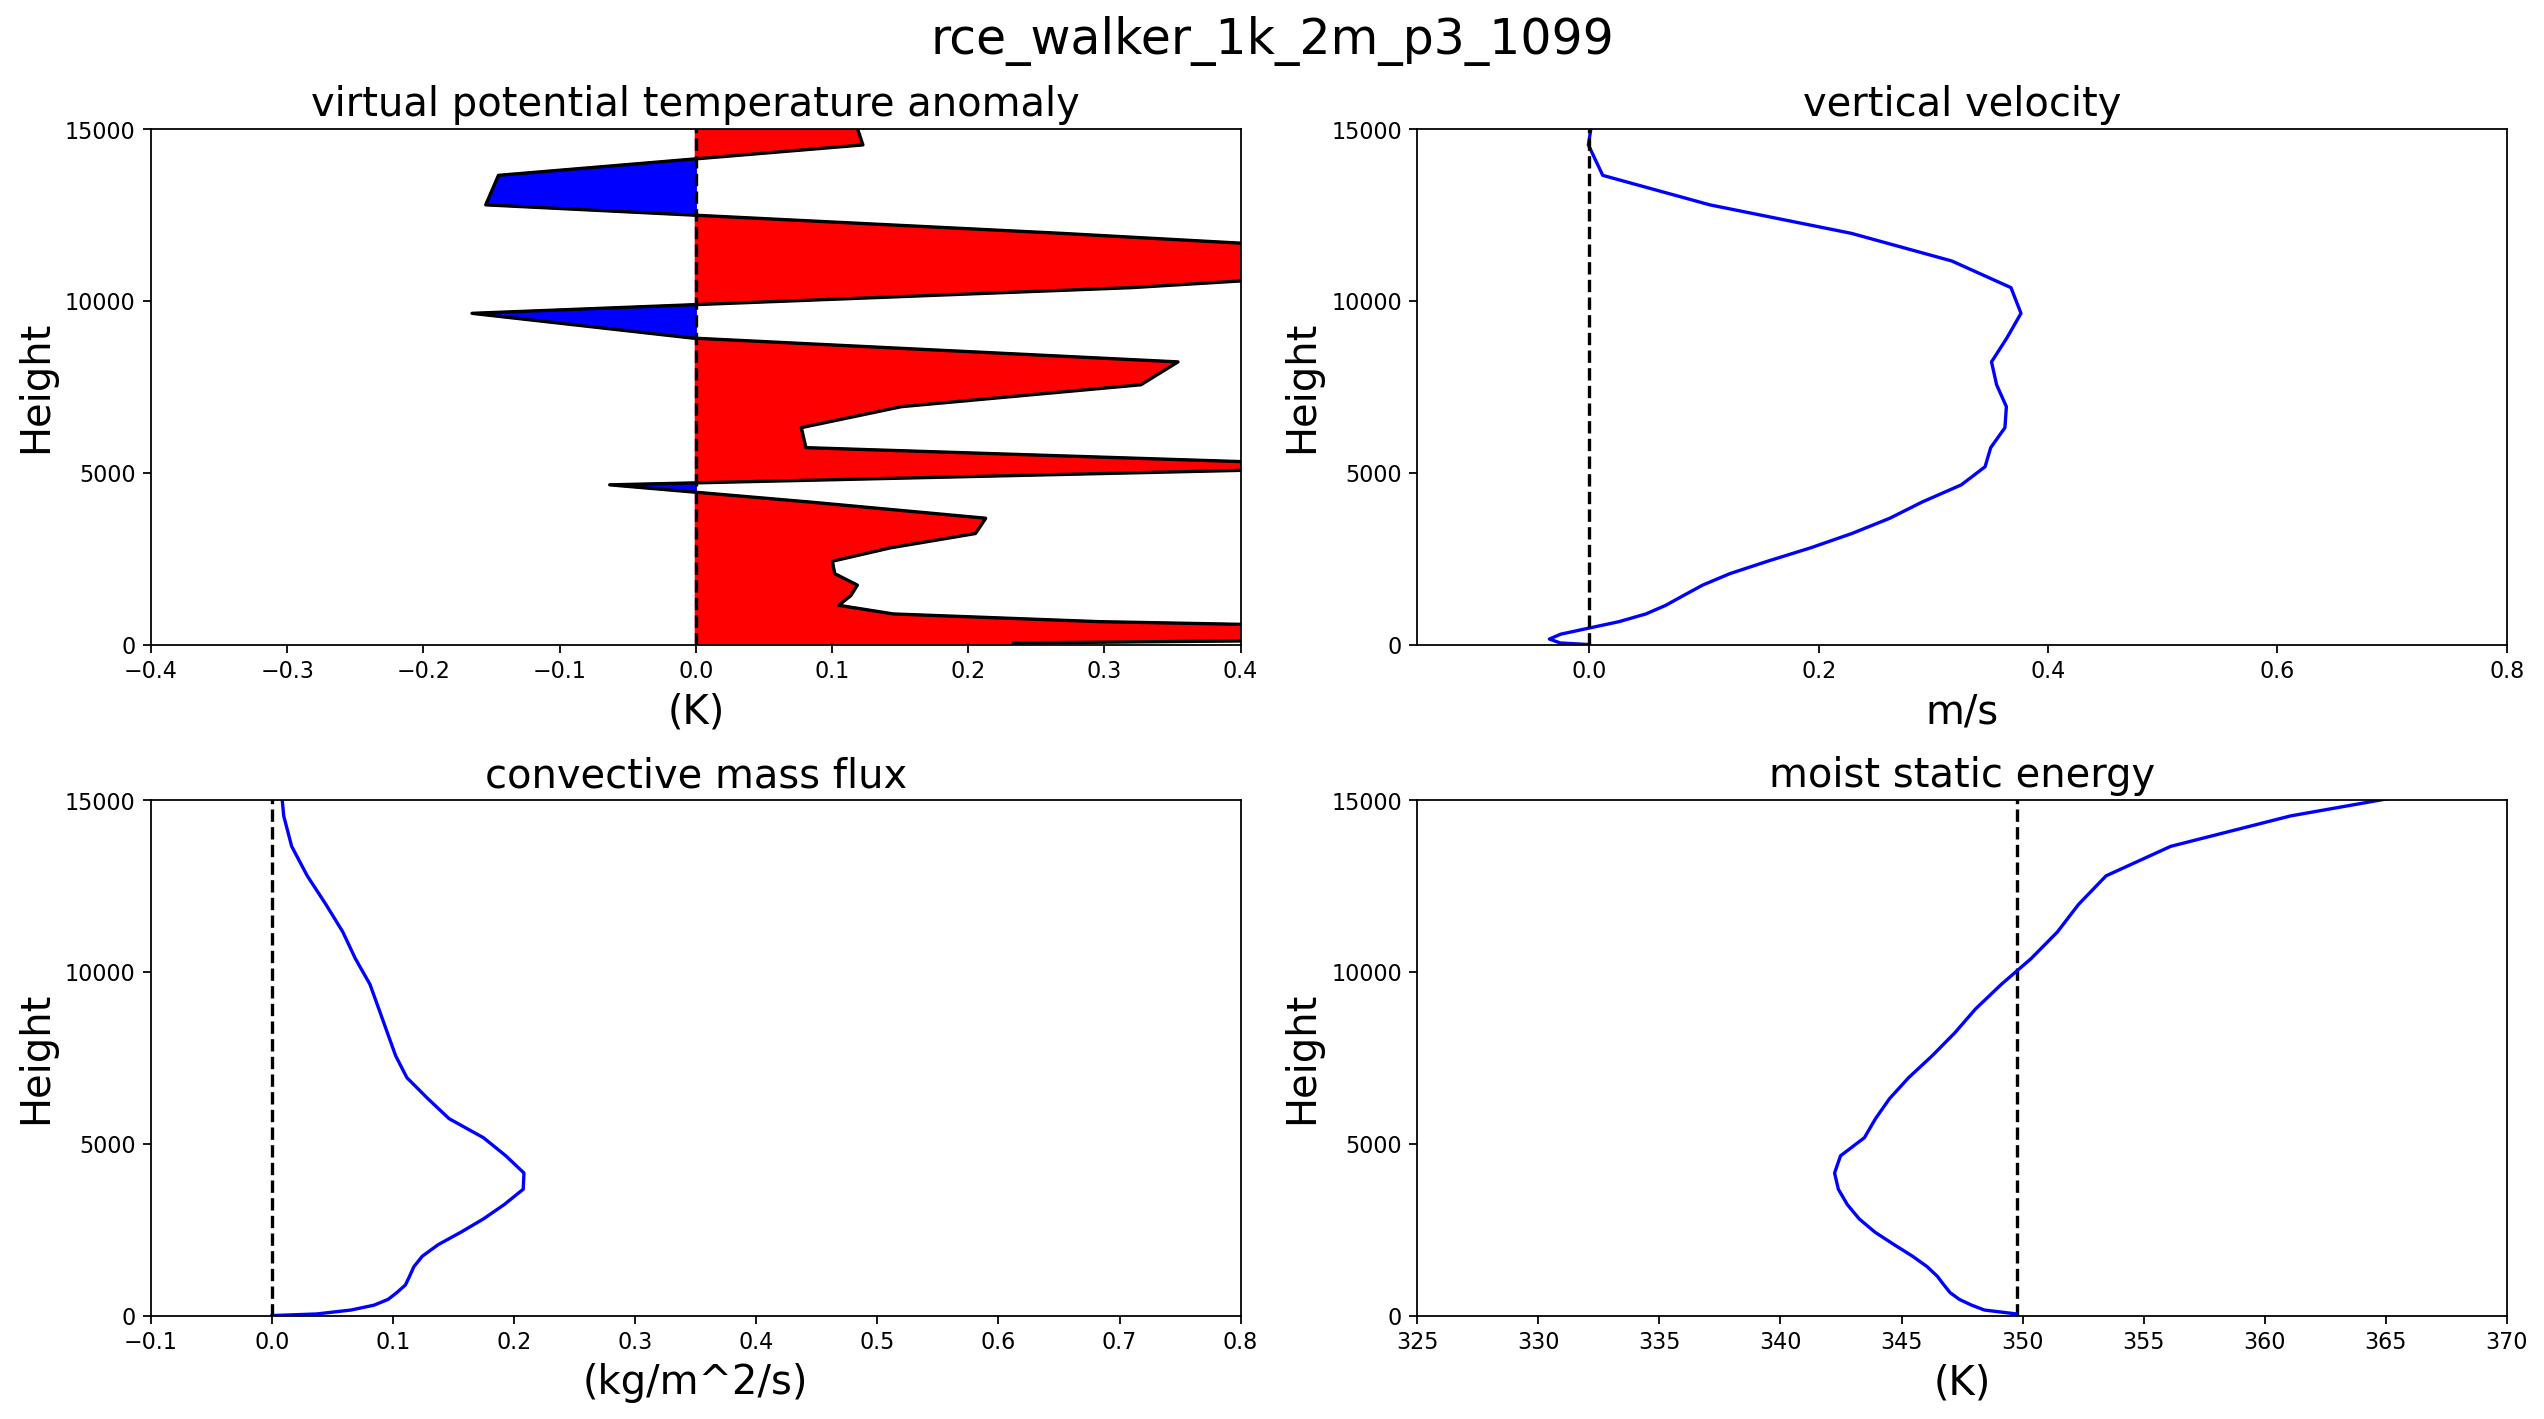

In [135]:
fig, axes = plt.subplots(nrows = 2,
                         ncols = 2,
                         figsize = (16, 9),
                         dpi = 160,
                         tight_layout=True)
fig.suptitle(f"{casenames[case_id][1:]}_{time}", fontsize = 22)

for idx, ax in enumerate(axes.flatten()):
    match idx:
        case 0:
            ax.plot(composite[0], zc[:z_index_len], 
                    color = "k")
            ax.plot(np.zeros_like(zc[:z_index_len]), zc[:z_index_len], 
                    color = "k",
                    linestyle = "dashed")
            ax.fill_betweenx(zc[:z_index_len], composite[0], color = "red", where = composite[0]>=0,interpolate = True)
            ax.fill_betweenx(zc[:z_index_len], composite[0], color = "b", where = composite[0]<=0,interpolate = True)
            #ax.fill_betweenx(zc[:z_index_len], np.where(composite[0] < 0, 0, composite[0]), color = "r")
            #ax.fill_betweenx(zc[:z_index_len], np.where(composite[0] > 0, 0, composite[0]), color = "b")
            ax.set_xlabel("(K)", fontsize = 18)
            ax.set_ylabel("Height", fontsize = 18)
            ax.set_xlim(-0.4,0.4)
            ax.set_ylim(0,15000)
            ax.set_yticks(np.linspace(0,15000,4))
            ax.set_title("virtual potential temperature anomaly", fontsize = 18)
            pass
        case 1:
            ax.plot(composite[1], zc[:z_index_len], 
                    color = "b")
            ax.plot(np.zeros_like(zc[:z_index_len]), zc[:z_index_len], 
                    color = "k",
                    linestyle = "dashed")
            ax.set_xlabel("m/s", fontsize = 18)
            ax.set_ylabel("Height", fontsize = 18)
            ax.set_xlim(-0.15,0.8)
            ax.set_ylim(0,15000)
            ax.set_yticks(np.linspace(0,15000,4))
            ax.set_title("vertical velocity", fontsize = 18)
            pass
        case 2:
            ax.plot(composite[2], zc[:z_index_len], 
                    color = "b")
            ax.plot(np.zeros_like(zc[:z_index_len]), zc[:z_index_len], 
                    color = "k",
                    linestyle = "dashed")
            ax.set_xlabel("(kg/m^2/s)", fontsize = 18)
            ax.set_ylabel("Height", fontsize = 18)
            ax.set_xlim(-0.1,0.8)
            ax.set_ylim(0,15000)
            ax.set_yticks(np.linspace(0,15000,4))
            ax.set_title("convective mass flux", fontsize = 18)
            pass
        case 3:
            ax.plot(np.full(shape = np.shape(composite[3]), fill_value = composite[3,0]), zc[:z_index_len], 
                    color = "k",
                    linestyle = "dashed")
            ax.plot(composite[3], zc[:z_index_len], 
                    color = "b")
            ax.set_xlabel("(K)", fontsize = 18)
            ax.set_ylabel("Height", fontsize = 18)
            ax.set_xlim(325,370)
            ax.set_ylim(0,15000)
            ax.set_yticks(np.linspace(0,15000,4))
            ax.set_title("moist static energy", fontsize = 18)
            pass
plt.savefig(f"{casenames[case_id][1:]}_{time}.png")